In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [18]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [58]:
#look at columns in station table

inspector = inspect(engine)

measurement_col = inspector.get_columns('measurement')
for column in measurement_col:
    print(column['name'], column['type'])
    
engine.execute('SELECT * FROM measurement LIMIT 3').all()

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0)]

In [59]:
#look at columns in station table
engine.execute('SELECT * FROM measurement LIMIT 3').fetchall()

station_col = inspector.get_columns('station')
for column in measurement_col:
    print(column['name'], column['type'])
    
engine.execute('SELECT * FROM station LIMIT 3').all()

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)]

In [54]:
# Find the most recent date in the data set.
newest_date = session.query(measurement.date) \
.order_by(measurement.date.desc()).first()
print(f'The most recent date in the data set is {newest_date}')

The most recent date in the data set is ('2017-08-23',)


In [78]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# newest_date

# Calculate the date one year from the last date in data set.
last_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
# last_date

# Perform a query to retrieve the data and precipitation scores
scores = session.query(measurement.date, measurement.prcp).filter \
    (measurement.date >= last_date). \
    order_by(measurement.date.desc()).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
score_df = pd.DataFrame(scores, columns=['Date', 'Participation']) \
    .set_index('Date')


# Sort the dataframe by date
date_score_df = score_df.sort_values(by='Date')
date_score_df

,Participation
Date,
2016-08-23,0.70
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,1.79
2016-08-23,NaN
...,...
2017-08-22,0.00
2017-08-23,0.45
2017-08-23,0.08


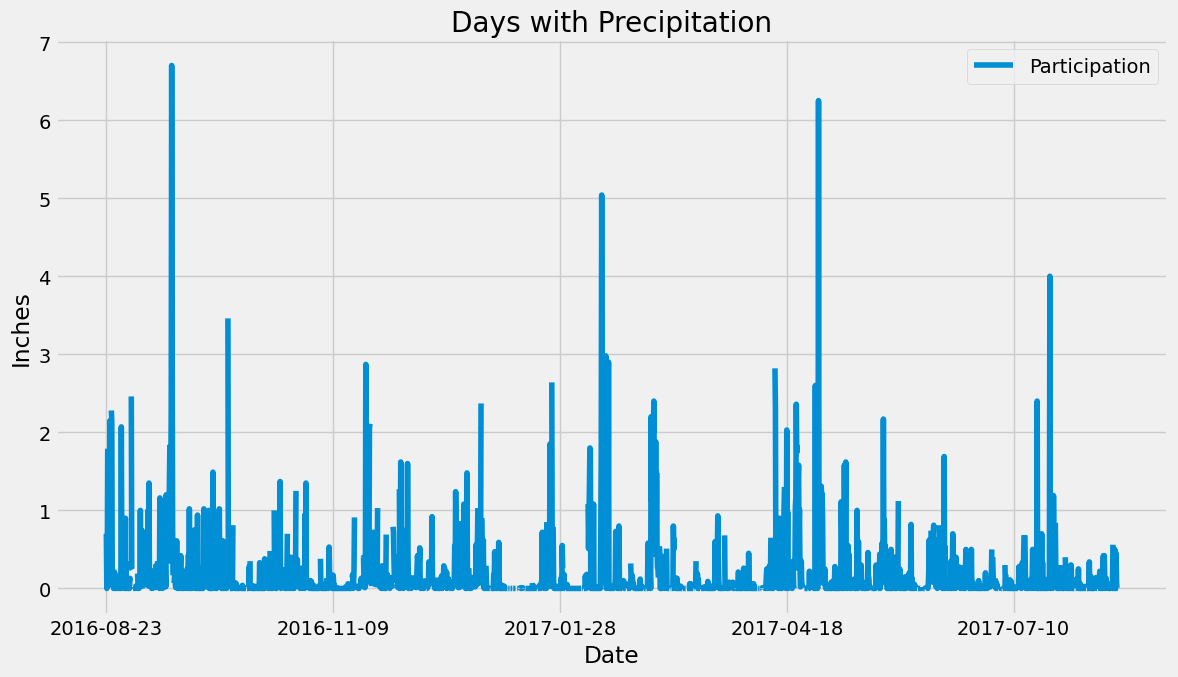

In [79]:
# Use Pandas Plotting with Matplotlib to plot the data
date_plot = date_score_df.plot(title = "Days with Precipitation", figsize=(12,7)).set(xlabel="Date", ylabel="Inches")
plt.tight_layout()
plt.show()

In [80]:
# Use Pandas to calcualte the summary statistics for the precipitation data
date_score_df.describe()

,Participation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [81]:
# Design a query to calculate the total number stations in the dataset
session.query(station.station).count()

9

In [148]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
best_stations = session.query(measurement.station, func.count(measurement.station)). \
    group_by(measurement.station). \
    order_by(func.count(measurement.station).desc()).all()
best_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [149]:
# Using the most active station id from the previous query, 
# calculate the lowest, highest, and average temperature.

most_active = best_stations[0][0]

active_statation_temp = session.query(func.min(measurement.tobs), \
                                      func.max(measurement.tobs), \
                                      func.avg(measurement.tobs)). \
                        filter(most_active == measurement.station).all()

print(f'The lowest temp in the most active station is {round(active_statation_temp[0][0])}')
print(f'The highest temp in the most active station is {round(active_statation_temp[0][1])}')
print(f'The average temp in the most active station is {round(active_statation_temp[0][2])}')

The lowest temp in the most active station is 54
The highest temp in the most active station is 85
The average temp in the most active station is 72


In [150]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_last_year_temps = session.query(measurement.station, measurement.date, measurement.tobs).\
    filter(measurement.station == most_active).\
    filter(measurement.date >= last_date).\
    order_by(measurement.date).all()

active_last_year_temps

[('USC00519281', '2016-08-23', 77.0),
 ('USC00519281', '2016-08-24', 77.0),
 ('USC00519281', '2016-08-25', 80.0),
 ('USC00519281', '2016-08-26', 80.0),
 ('USC00519281', '2016-08-27', 75.0),
 ('USC00519281', '2016-08-28', 73.0),
 ('USC00519281', '2016-08-29', 78.0),
 ('USC00519281', '2016-08-30', 77.0),
 ('USC00519281', '2016-08-31', 78.0),
 ('USC00519281', '2016-09-01', 80.0),
 ('USC00519281', '2016-09-02', 80.0),
 ('USC00519281', '2016-09-03', 78.0),
 ('USC00519281', '2016-09-04', 78.0),
 ('USC00519281', '2016-09-05', 78.0),
 ('USC00519281', '2016-09-06', 73.0),
 ('USC00519281', '2016-09-07', 74.0),
 ('USC00519281', '2016-09-08', 80.0),
 ('USC00519281', '2016-09-09', 79.0),
 ('USC00519281', '2016-09-10', 77.0),
 ('USC00519281', '2016-09-11', 80.0),
 ('USC00519281', '2016-09-12', 76.0),
 ('USC00519281', '2016-09-13', 79.0),
 ('USC00519281', '2016-09-14', 75.0),
 ('USC00519281', '2016-09-15', 79.0),
 ('USC00519281', '2016-09-16', 78.0),
 ('USC00519281', '2016-09-17', 79.0),
 ('USC005192

[Text(0, 0.5, 'Frequency'), Text(0.5, 0, 'Temperature')]

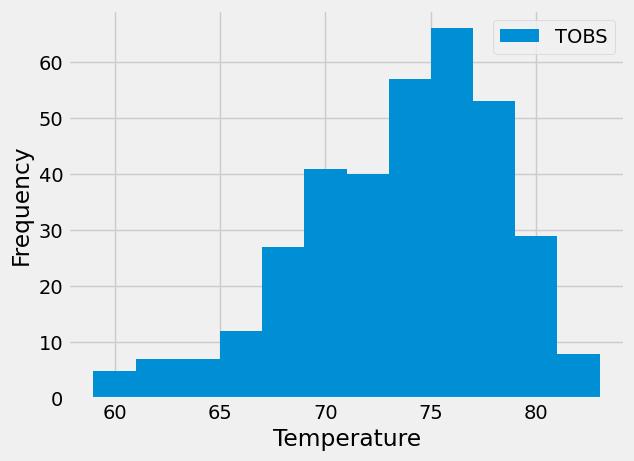

In [151]:
# Plot the results as a histogram with bins=12
temp_histogram = pd.DataFrame(active_last_year_temps, \
                              columns=["Station", "Date", "TOBS"]).\
                                sort_values(by='Station', ascending=True)

temp_histogram.set_index('Station')

temp_histogram.plot.hist(bins=12).set(ylabel='Frequency', xlabel='Temperature')



# Close session

In [153]:
# Close Session
session.close()